# Training the model

In [123]:
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))


In [124]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

#progress bar
from tqdm import trange
from tqdm import tqdm

In [125]:
#torch.set_default_dtype(torch.float64)
#torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

In [126]:
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


## Loading and preparing data

In [127]:
# Load and filter data
data = pd.read_csv("/kaggle/input/airbnbdata-barcelona/listing_data_lower_dimension.csv")
data = data.select_dtypes(exclude=['object', 'string'])
data = data.drop("id", axis=1)

# Define target column
target_clm = "price"

# Drop rows with missing target
data = data.dropna(subset=[target_clm])

# Create an imputer that fills NaNs with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on your data and transform it
data_imputed = imputer.fit_transform(data)

# Convert back to DataFrame to keep column names
data = pd.DataFrame(data_imputed, columns=data.columns)  

In [128]:
test_size = 0.2
train_df, test_df = train_test_split(data, test_size=test_size, random_state=42)

# Normalization stats from training data
train_mean = train_df.drop(target_clm, axis=1).mean().astype(np.float32).values
train_std = train_df.drop(target_clm, axis=1).std().replace(0, 1).astype(np.float32).values


## Dataset

In [129]:
class TabularDataset(Dataset):
    def __init__(self, df, target_clm, mean=None, std=None, normalize=True):
        self.X = df.drop(target_clm, axis=1).to_numpy(dtype=np.float32)
        self.y = df[target_clm].to_numpy(dtype=np.float32)
        self.mean = mean
        self.std = std
        self.normalize = normalize

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.normalize and self.mean is not None and self.std is not None:
            x = (x - self.mean) / self.std
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [130]:
# Datasets
train_dataset_full = TabularDataset(train_df, target_clm, train_mean, train_std, normalize=True)
test_dataset = TabularDataset(test_df, target_clm, train_mean, train_std, normalize=True)

# Split train/val
torch.manual_seed(0)
val_ratio = 0.1
train_dataset, val_dataset = random_split(train_dataset_full, [1 - val_ratio, val_ratio])

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [131]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)

    def forward(self, x):
        return self.linear(x).squeeze()  # Squeeze to match target shape


In [146]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
input_dim = train_df.drop(target_clm, axis=1).shape[1]
model = LinearRegressionModel(input_dim).to(device)
model = model.float()
# Loss and optimizer
criterion = nn.HuberLoss(delta=1.0)
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)


In [133]:
print("Any NaN in features? ", np.isnan(data.drop(target_clm, axis=1).to_numpy()).any())
print("Any NaN in target? ", np.isnan(data[target_clm].to_numpy()).any())

Any NaN in features?  False
Any NaN in target?  False


In [134]:
def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    model.train()
    train_loss = 0.0
    for batch in dataloader:
        X, y = batch
        X, y = X.to(device), y.to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        #Backward pass
        loss.backward()
        optimizer.step()

        #calculate step quality
        train_loss += loss.item()

        master_bar.set_description(f"Epoch {master_bar.n + 1} (Train)")
        master_bar.set_postfix(loss=f"{loss.item():.3f}")

    return train_loss / len(dataloader)

        

In [135]:
def validate(dataloader, model, loss_fn, device, master_bar):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)

            #validate
            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss += loss.item()

            master_bar.set_description(f"Epoch {master_bar.n + 1} (Validate)")
            master_bar.set_postfix(loss=f"{loss.item():.3f}")
    
    return val_loss / len(dataloader)

In [136]:
def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    train_losses = []
    val_losses = []

    master_bar = trange(num_epochs, desc="Training Epochs")
    for epoch in master_bar:
        train_loss = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        val_loss = validate(val_dataloader, model, loss_function, device, master_bar)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [137]:
def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)
    absolute_errors = []

    with torch.no_grad():
        for batch in dataloader:
            # Assumes batch is (inputs, targets)
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            predictions = model(inputs)
            abs_errors = abs(predictions - targets)
            
            absolute_errors.extend(abs_errors.cpu().numpy())

    return np.array(absolute_errors)

In [138]:
def plot_accuracy(errors, bins = 10, min_range = None, max_range = None):

    if min_range is None:
        min_range = min(errors)
    if max_range is None:
        max_range = max(errors)

    counts, bin_edges = np.histogram(errors, bins=bins, range=(min_range, max_range))

    percentages = 100 * counts / counts.sum()

    bin_widths = bin_edges[1:] - bin_edges[:-1]

    plt.bar(bin_edges[:-1], percentages, width = bin_widths, align = 'edge', edgecolor='black')
    plt.xlabel("Absolute Error")
    plt.ylabel("Percentage (%)")
    plt.title("Percentage Distribution of Absolute Errors")
    
    #plt.hist(errors, bins, range=(min_range, max_range), density=True)
    plt.grid(True)
    plt.show() 

In [139]:
def plotLosses(losses, title = ""):
    plt.plot(range(1, len(losses) + 1),losses, label=title + " loss")
    plt.legend()
    plt.title(title + " loss per epoch")
    plt.show()

In [147]:
epochs=50

losses = run_training(model, optimizer, criterion, device, epochs, train_loader, val_loader)


Epoch 50 (Validate): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s, loss=47.349] 


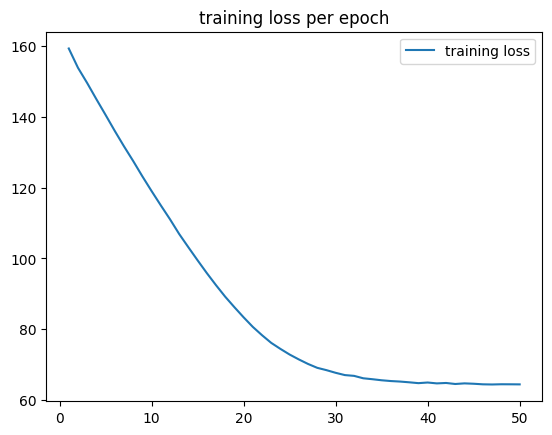

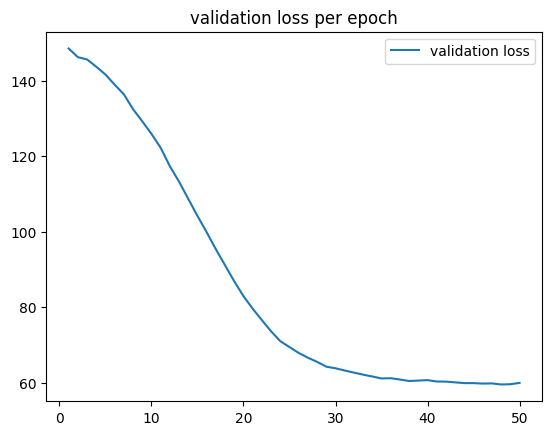

In [148]:
plotLosses(losses[0], "training")
plotLosses(losses[1], "validation")

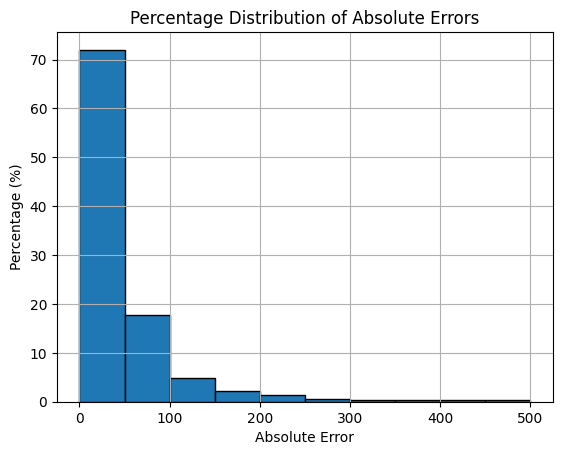

In [149]:
#evaluate
err = evaluate_model(model, test_loader, device)
plot_accuracy(err, bins = 10, min_range = 0, max_range = 500)

In [150]:
#true vs predicted graph
def plot_true_vs_predicted(model, dataloader, device):
    model.eval()
    model.to(device)
    true_y = []
    predicted_y = []

    with torch.no_grad():
        for batch in dataloader:
            # Assumes batch is (inputs, targets)
            tab, targets = batch
            tab = tab.to(device)
            targets = targets.to(device)

            outputs = model(tab)
            
            # Move tensors to CPU and convert to numpy
            predicted_y.append(outputs.cpu().numpy())
            true_y.append(targets.cpu().numpy())

    # Concatenate all batch results
    true_y = np.concatenate(true_y)
    predicted_y = np.concatenate(predicted_y)

    plt.figure(figsize=(10, 6))
    plt.scatter(true_y, predicted_y, alpha=0.5)
    plt.plot([true_y.min(), true_y.max()], [true_y.min(), true_y.max()], 'k--', lw=2)  # Diagonal line
    plt.xlabel("True Price")
    plt.ylabel("Predicted Price")
    plt.xlim(0, 500)  
    plt.ylim(0, 500)
    plt.title("True vs Predicted Price")
    plt.grid(True)
    plt.show()

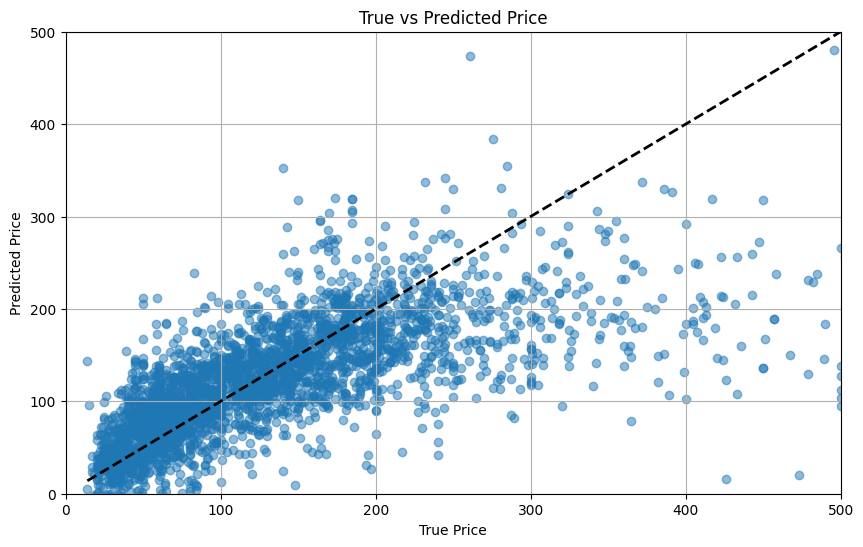

In [151]:
plot_true_vs_predicted(model, test_loader, device)

Epoch 30 (Validate): 100%|██████████| 30/30 [00:28<00:00,  1.07it/s, loss=124.298]


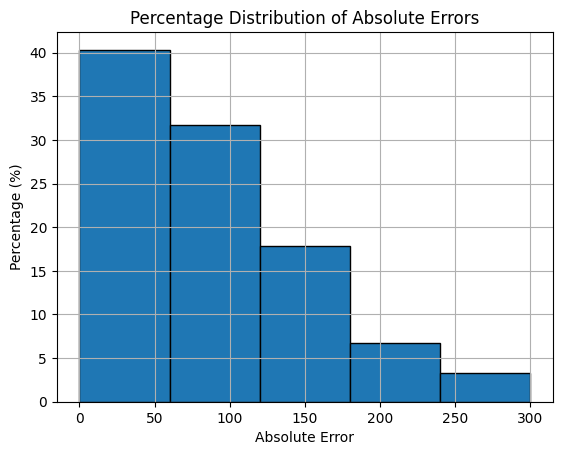

In [145]:
#Testing other optimizers (Adagrad is very efficient for our sparse data)
optimizer = torch.optim.Adagrad(model.parameters())
epochs=30

run_training(model, optimizer, criterion, device, epochs, train_loader, val_loader)
err = evaluate_model(model, test_loader, device)
plot_accuracy(err, bins = 5, min_range = 0, max_range = 300)